In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import bidi.algorithm
import arabic_reshaper
import adhtools.utils

In [2]:
fpath = '/media/sf_VBox_Shared/Arabic/Analyses/Fiqh_final2/topicmodeling/fiqh-light10-20/'

In [3]:
df_topics = pd.read_csv(os.path.join(fpath, 'fiqh_topics_20_labeled.csv'), sep=';', index_col=0).fillna('')

In [4]:
df_topics['label'] = df_topics[['topic_level1', 'topic_level2']].apply(lambda r: ' - '.join([s for s in r if s!='']), axis=1)
df_topics

,0,1,2,3,4,5,6,7,8,9,topic_level1,topic_level2,order,label
topic,,,,,,,,,,,,,,
0,اذ,دار,علي,قتل,امام,حرب,اهل,اسلام,ول,مسلم,public law,warfare,13,public law - warfare
1,يد,نفس,عمد,رجل,اذ,قصاص,قطع,ول,حد,قتل,public law,homicide; punishments,12,public law - homicide; punishments
2,سحن,اشهب,كتاب,مدون,ول,هذ,فل,اذ,مالك,قاسم,legal reasoning: Mālikīs,,20,legal reasoning: Mālikīs
3,نجس,مسح,حيض,دم,نجاس,صلا,وض,اذ,ول,غسل,ritual law,purity; prayer,1,ritual law - purity; prayer
4,خيار,هذ,ول,بااع,اذ,قبض,عقد,ثمن,مشتر,بيع,private law,contracts: sales,8,private law - contracts: sales
5,هذ,سلام,ركع,وقت,اول,صل,ول,اذ,امام,صلا,ritual law,prayer,2,ritual law - prayer
6,عد,فل,مهر,ام,حد,اذ,نكاح,ول,طلاق,زوج,personal law,marriage,6,personal law - marriage
7,دم,طواف,محرم,احرام,عمر,حرم,اذ,صيد,ول,حج,ritual law,pilgrimage,4,ritual law - pilgrimage
8,هذ,حق,حد,يد,اذ,مدع,قاض,اقرار,ول,شهاد,procedural law,litigation; proof,11,procedural law - litigation; proof


In [5]:
document_topics = pd.read_csv(os.path.join(fpath, 'document_topics_20.csv'), index_col=0).sort_index()
#df_topics = pd.read_csv(os.path.join(fpath, 'fiqh_roots_topics_20.csv'), index_col=0)
metadata = pd.read_csv(os.path.join(fpath, '../../metadata-chapters.csv'), index_col=0)

In [6]:
metadata_all = pd.read_csv('/media/sf_VBox_Shared/Arabic/fiqh_corpus/Meta/Metadata_Fiqh.csv')
#metadata_all = metadata_all[['BookURI', 'header_1', 'header_2', 'header_3', 'quran', 'hadith']]
metadata = metadata[['BookURI', 'ChapterLength', 'Level1Title', 'Level2Title', 'filename']].merge(metadata_all, how='left', left_on='BookURI', right_on='BookURI')

In [7]:
# How many books have fewer than 20 chapters?
chapter_counts = metadata.BookURI.value_counts(ascending=True)
chapter_counts[chapter_counts<20]

0972IbnAhmadIbnNajjarHanbali.MuntahaIradat     1
0726AlHilli.alTadhkira                         1
1186Albahrani.AlhadaCiqalalNadira              1
0597IbnJawzi.TahqiqFiAhadithKhilaf             9
0776Aljundi.AltawdihFiShafh                   14
0453alMaziri.SharhAltalqin                    19
0995Manjur.SharhManhajMuntakhab               19
Name: BookURI, dtype: int64

In [8]:
# How many books have no chapter information?
metadata_all[metadata_all.header_2<1]

,BookURI,BookSource,BookTITLE_SHORT,BookTITLE,BookSUBJ,Number_of_tokens,AuthorNAME_SHORT,AuthorNAME,AuthorBORNH,AuthorBORNC,AuthorDIEDH,AuthorDIEDC,Century,Author_Geographical_Area,BookVOLS,header_1,header_2,header_3,quran,hadith
5,0995Manjur.SharhManhajMuntakhab,http://shamela.ws/index.php/book/18279,شرح المنهج المنتخب,شرح المنهج المنتخب إلى قواعد المذهب,مالكي,126657,المنجور,المنجور أحمد بن علي المنجور,NODATA,NODATA,995,NODATA,10th/16th century,Islamic West,2,19,0,0,66,0
6,0972IbnAhmadIbnNajjarHanbali.MuntahaIradat,http://shamela.ws/index.php/book/13664,منتهى الإرادات,منتهى الإرادات,حنبلي,140806,ابن النجار,تقي الدين محمد بن أحمد الفتوحي الحنبلي الشهير ...,898,1492,972,1564,10th/16th century,Fertile Crescent,5,1,0,0,9,0
11,1335IbnCabdSamicAbiAzhari.ThamrDani,http://shamela.ws/index.php/book/7441,الثمر الداني,الثمر الداني في تقريب المعاني شرح رسالة ابن أب...,مالكي,174005,الأزهري,صالح عبد السميع الآبي الأزهري,NODATA,NODATA,1335,1916,13th/19th century,Islamic West,1,36,0,0,119,0
14,0597IbnJawzi.TahqiqFiAhadithKhilaf,http://shamela.ws/index.php/book/5907,التحقيق,التحقيق في أحاديث الخلاف,حنبلي,215473,ابن الجوزي,عبد الرحمن بن علي بن محمد بن الجوزي أبو الفرج,508,1126,597,1200,06th/012th century,Fertile Crescent,2,9,0,0,39,0
24,0598alHilli.alSarair,http://shiaonlinelibrary.com/الكتب/49_السرائر-...,السرائر,السرائر,جعفري,516557,ابن ادريس,اِبن إدريس أبو عبد الله محمد العِجلي الحلّي,543,1148,598,1201,06th/012th century,Fertile Crescent,3,31,0,0,0,0
26,0726AlHilli.alTadhkira,http://shiaonlinelibrary.com/الكتب/75_تذكرة-ال...,تذكرة الفقهاء,تذكرة الفقهاء,جعفري,714294,العلامة الحلي,ابن المطهر الحلي هو جمال الدين الحسن بن يوسف ب...,648,1250,726,1325,08th/014th century,Fertile Crescent,14,0,0,0,0,0
30,0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFuruc.,http://shamela.ws/index.php/book/12052,الفروع,الفروع وتصحيح الفروع,حنبلي,845176,ابن مفلح,محمد بن مفلح المقدسي أبو عبد الله,717,1308,763,1362,08th/014th century,Fertile Crescent,2,41,0,0,190,0
31,1310BakriDimyati.HashiyaIcanaTalibin,http://shamela.ws/index.php/book/963,حاشية الدمياطي,حاشية إعانة الطالبين على حل ألفاظ فتح المعين ل...,شافعي,961599,الدمياطي,أبي بكر ابن السيد محمد شطا الدمياطي,1302,1885,1369,1950,13th/19th century,Arabian Peninsula,4,22,0,0,353,0
34,0841JamalDinIbnFahdHilli.MuhadhdhabBaric,http://ar.lib.eshia.ir/10053/1/4,المهذب البارع,المهذب البارع في شرح المختصر النافع,جعفري,998921,ابن فهد,أبو العباس جمال الدين أحمد بن شمس الدين محمد ب...,756,1355,841,1437,09th/015th century,Fertile Crescent,5,51,0,0,0,0
37,0776Aljundi.AltawdihFiShafh,http://shamela.ws/index.php/book/14442,التوضيح,التوضيح في شرح مختصر ابن الحاجب خليل بن إسحاق ...,مالكي,1177391,خليل بن اسحاق,خليل بن إسحاق بن موسى، ضياء الدين الجندي المال...,NODATA,NODATA,776,1365,08th/014th century,Fertile Crescent,8,14,0,0,317,0


In [9]:
#books_exclude = list(metadata_all[metadata_all.header_2<1]['BookURI'])
books_exclude = chapter_counts[chapter_counts<20].index
print('Excluded books:')
print(books_exclude)

Excluded books:
Index(['0972IbnAhmadIbnNajjarHanbali.MuntahaIradat', '0726AlHilli.alTadhkira',
       '1186Albahrani.AlhadaCiqalalNadira',
       '0597IbnJawzi.TahqiqFiAhadithKhilaf', '0776Aljundi.AltawdihFiShafh',
       '0453alMaziri.SharhAltalqin', '0995Manjur.SharhManhajMuntakhab'],
      dtype='object')


In [10]:
topic_names = df_topics['label']

In [11]:
print(df_topics.topic_level1.unique())

['public law' 'legal reasoning: Mālikīs' 'ritual law' 'private law'
 'personal law' 'procedural law' 'legal reasoning: Ḥanafīs'
 'legal reasoning' 'legal reasoning: Shāfiʿīs']


In [12]:
# level1_order = ['ritual law', 'personal law', 'private law', 'procedural law', 'public law']
# level1_order = level1_order + list(set(df_topics.topic_level1.unique()).difference(set(level1_order)))
# print(level1_order)
# #topic_order = sorted(topic_names, reverse=True)
# df_test = df_topics[['topic_level1','topic_level2','label']].copy()
# df_test['sort'] = [dict(zip(level1_order, range(len(level1_order))))[i] for i in df_test['topic_level1']]
# topic_order = df_test.sort_values(['sort', 'topic_level2'])['label']
# print(topic_order)

In [13]:
topic_order = df_topics.sort_values('order')['label'].values

In [14]:
def split_fname(fname):
    splitted = fname.split('-')
    bookname = splitted[0]
    if len(splitted)>1:
        chapter = int(splitted[-1].split('.')[0])
    else:
        chapter = 0
    return (bookname, chapter)

In [15]:
metadata['filename'] = metadata.filename.astype(str)

In [16]:
# Filter on excluded books
metadata_newind = metadata #[~metadata.BookURI.isin(books_exclude)].copy()
metadata_newind.index = pd.MultiIndex.from_tuples(metadata_newind.filename.map(split_fname))

In [17]:
largest_topics = pd.DataFrame(document_topics.idxmax(axis=1))#, index=metadata_newind.index)
largest_topics.index = metadata_newind.index

# Filter on excluded books
metadata_newind = metadata_newind[~metadata_newind.BookURI.isin(books_exclude)].copy()
largest_topics = largest_topics.loc[metadata_newind.index].copy()

largest_topics = pd.concat((largest_topics,  metadata_newind['ChapterLength'], metadata_newind['Number_of_tokens']), axis=1)

#largest_topics.index = new_ind
largest_topics = largest_topics.reset_index()
largest_topics.columns = ['book', 'chapter', 'topic', 'length', 'total_length']

In [18]:
book_names = sorted(metadata_newind.BookURI.unique())

In [19]:
book_dict = {b: i for i,b in enumerate(book_names)}

In [20]:
metadata_newind['topic'] = largest_topics.set_index(['book', 'chapter'])['topic']
metadata_newind['topic_name'] = [topic_names[int(topic)] for topic in metadata_newind['topic']]
metadata_newind['topic_level1'] = [df_topics.topic_level1[int(topic)] for topic in metadata_newind['topic']]
metadata_newind['topic_level2'] = [df_topics.topic_level2[int(topic)] for topic in metadata_newind['topic']]

In [21]:
metadata_newind.to_csv(os.path.join(fpath, 'chapters_metadata_topics.csv'))

In [22]:
largest_topics['x1'] = largest_topics.groupby('book')['length'].transform(pd.Series.cumsum)
largest_topics['x0'] = largest_topics['x1'] - largest_topics['length']

In [23]:
largest_topics['total_length'] = largest_topics.groupby('book')['x1'].transform(lambda l: [l.max()]*len(l))

In [24]:
largest_topics['perc0'] = largest_topics['x0'] / largest_topics['total_length']
largest_topics['perc1'] = largest_topics['x1'] / largest_topics['total_length']

In [25]:
largest_topics['label'] = [topic_names[int(t)] for t in largest_topics['topic']]

In [26]:
largest_topics = largest_topics.merge(df_topics[['topic_level1', 'topic_level2', 'label']], how='left')

In [27]:
largest_topics.to_csv(os.path.join(fpath, 'largest_topics_20.csv'), index=False)

create color palette based on the two levels

In [28]:
topics_level1_sorted = df_topics.sort_values('order')['topic_level1'].drop_duplicates()
nested_topics = {t: list(df_topics[df_topics.topic_level1==t].sort_values('order')['topic_level2']) for t in topics_level1_sorted}

In [29]:
level1_counts = {k: len(nested_topics[k]) for k in nested_topics}

In [30]:
# Count the number of distincts topics per highest level
level1_counts

{'ritual law': 5,
 'personal law': 2,
 'private law': 3,
 'procedural law': 1,
 'public law': 2,
 'legal reasoning': 4,
 'legal reasoning: Ḥanafīs': 1,
 'legal reasoning: Shāfiʿīs': 1,
 'legal reasoning: Mālikīs': 1}

## Plot the topics

Each topic label gets a color assigned. Here we show the color per topic, in the table with the most important words per topic. The topics are sorted on label.

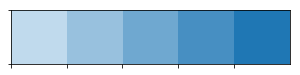

ritual law - purity; prayer
ritual law - prayer
ritual law - oaths; fasting; expiation
ritual law - pilgrimage
ritual law - alms; taxes


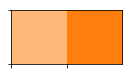

personal law - marriage
personal law - inheritance


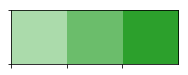

private law - contracts: sales
private law - contracts: estates
private law - slaves


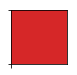

procedural law - litigation; proof


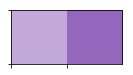

public law - homicide; punishments
public law - warfare


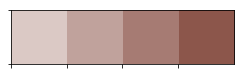

legal reasoning
legal reasoning - general; akhbār
legal reasoning - general; khilāf
legal reasoning - prophetic hadith and early authorities


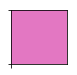

legal reasoning: Ḥanafīs


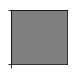

legal reasoning: Shāfiʿīs


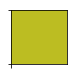

legal reasoning: Mālikīs


In [31]:
color_dict = {}
start_colors = sns.color_palette(n_colors=len(level1_counts))
for i, topic_lev1 in enumerate(topics_level1_sorted):
    if topic_lev1 != 'noise':
        c = start_colors[i] #tuple((np.random.random() for _ in range(3)))
        level2_counts = level1_counts[topic_lev1]
        cmap_sub = sns.light_palette(c, level2_counts+1)[1:]
        sns.palplot(cmap_sub)
        plt.show()
        for j, topic_lev2 in enumerate(nested_topics[topic_lev1]):
            label = topic_lev1
            if topic_lev2 != '':
                label+= ' - ' + topic_lev2
            color_dict[label] = cmap_sub[j]
            print(label)
            

In [32]:
#color_list = sns.color_palette(n_colors=len(topic_names))
# color_list = sns.color_palette("muted", n_colors=10) + sns.color_palette("dark", n_colors=10)
# color_dict = {label: color_list[i] for i,label in enumerate(topic_names)}
color_dict['noise'] = 'grey'

In [33]:
import matplotlib.colors

def style_row(row):
    topic_id = int(row.name)
    topic_name = row.label
    color = matplotlib.colors.to_hex(color_dict[topic_name])
    attr = 'background-color: {}'.format(color)
    return [attr for v in  row]
df_topics.reset_index().set_index('label').reindex(topic_order).reset_index().set_index('topic').style.apply(style_row, axis=1)

,label,0,1,2,3,4,5,6,7,8,9,topic_level1,topic_level2,order
topic,,,,,,,,,,,,,,
3,ritual law - purity; prayer,نجس,مسح,حيض,دم,نجاس,صلا,وض,اذ,ول,غسل,ritual law,purity; prayer,1
5,ritual law - prayer,هذ,سلام,ركع,وقت,اول,صل,ول,اذ,امام,صلا,ritual law,prayer,2
18,ritual law - oaths; fasting; expiation,نذر,يحنث,اذ,حنث,يم,ول,حلف,يوم,كفار,صوم,ritual law,oaths; fasting; expiation,3
7,ritual law - pilgrimage,دم,طواف,محرم,احرام,عمر,حرم,اذ,صيد,ول,حج,ritual law,pilgrimage,4
10,ritual law - alms; taxes,حد,اذ,نصاب,خمس,عشر,صدق,حول,مال,ول,زكا,ritual law,alms; taxes,5
6,personal law - marriage,عد,فل,مهر,ام,حد,اذ,نكاح,ول,طلاق,زوج,personal law,marriage,6
17,personal law - inheritance,موص,ورث,ثلاث,نصف,عشر,ام,مال,اب,وص,ثلث,personal law,inheritance,7
4,private law - contracts: sales,خيار,هذ,ول,بااع,اذ,قبض,عقد,ثمن,مشتر,بيع,private law,contracts: sales,8
15,private law - contracts: estates,دار,اخذ,ملك,عمل,فل,اذ,اجر,ول,ارض,مال,private law,contracts: estates,9


In [34]:
df_topics_colors = df_topics.copy().sort_values('order')
#df_topics_colors['color'] = [color_dict[l] for l in df_topics.label]
df_topics_colors.head()

,0,1,2,3,4,5,6,7,8,9,topic_level1,topic_level2,order,label
topic,,,,,,,,,,,,,,
3,نجس,مسح,حيض,دم,نجاس,صلا,وض,اذ,ول,غسل,ritual law,purity; prayer,1,ritual law - purity; prayer
5,هذ,سلام,ركع,وقت,اول,صل,ول,اذ,امام,صلا,ritual law,prayer,2,ritual law - prayer
18,نذر,يحنث,اذ,حنث,يم,ول,حلف,يوم,كفار,صوم,ritual law,oaths; fasting; expiation,3,ritual law - oaths; fasting; expiation
7,دم,طواف,محرم,احرام,عمر,حرم,اذ,صيد,ول,حج,ritual law,pilgrimage,4,ritual law - pilgrimage
10,حد,اذ,نصاب,خمس,عشر,صدق,حول,مال,ول,زكا,ritual law,alms; taxes,5,ritual law - alms; taxes


In [35]:
df_topics_colors.to_csv(os.path.join(fpath, 'fiqh_topics_20_labeled_ordered.csv'))

In [36]:
def plot_bar_per_book(largest_topics, xmin_col, xmax_col, book_names, topic_names, legend=True, figsize=None, lw=None):
    book_dict = {b: i for i,b in enumerate(book_names)}

    if figsize is None:
        plt.figure(figsize=(25, np.floor(len(book_names)*0.5)))
    else:
        plt.figure(figsize=figsize)
    if lw is None:
        lw = 10
    ax = plt.gca()
    for topic_name in sorted(topic_names):
        largest_topics_sub = largest_topics[largest_topics['label']==topic_name]
        #color = color_list[topic] 
        color = color_dict[topic_name]

        y = [book_dict[s] for s in largest_topics_sub['book']]
        #x = largest_topics_sub['chapter']
        xmin = largest_topics_sub[xmin_col]
        xmax = largest_topics_sub[xmax_col]
        if topic_name != 'noise':
            ax.hlines(y, xmin, xmax, #marker='s', edgecolors=None, 
                      colors=np.array((color,)), lw=lw,
                       label=bidi.algorithm.get_display(arabic_reshaper.reshape(topic_name)))
    ax.set_yticks(np.arange(len(book_dict)))
    ax.set_yticklabels(book_names)
    ax.set_xlim(0, largest_topics[xmax_col].max())
    ax.set_ylim(-0.5, len(book_names))
    if legend:
        plt.legend(fontsize='large')
    ax.invert_yaxis()
    #ax.set_facecolor('black')
    plt.show()

We plot the topics per book, based on the absolute length (in number of tokens) of the chapters in the book.

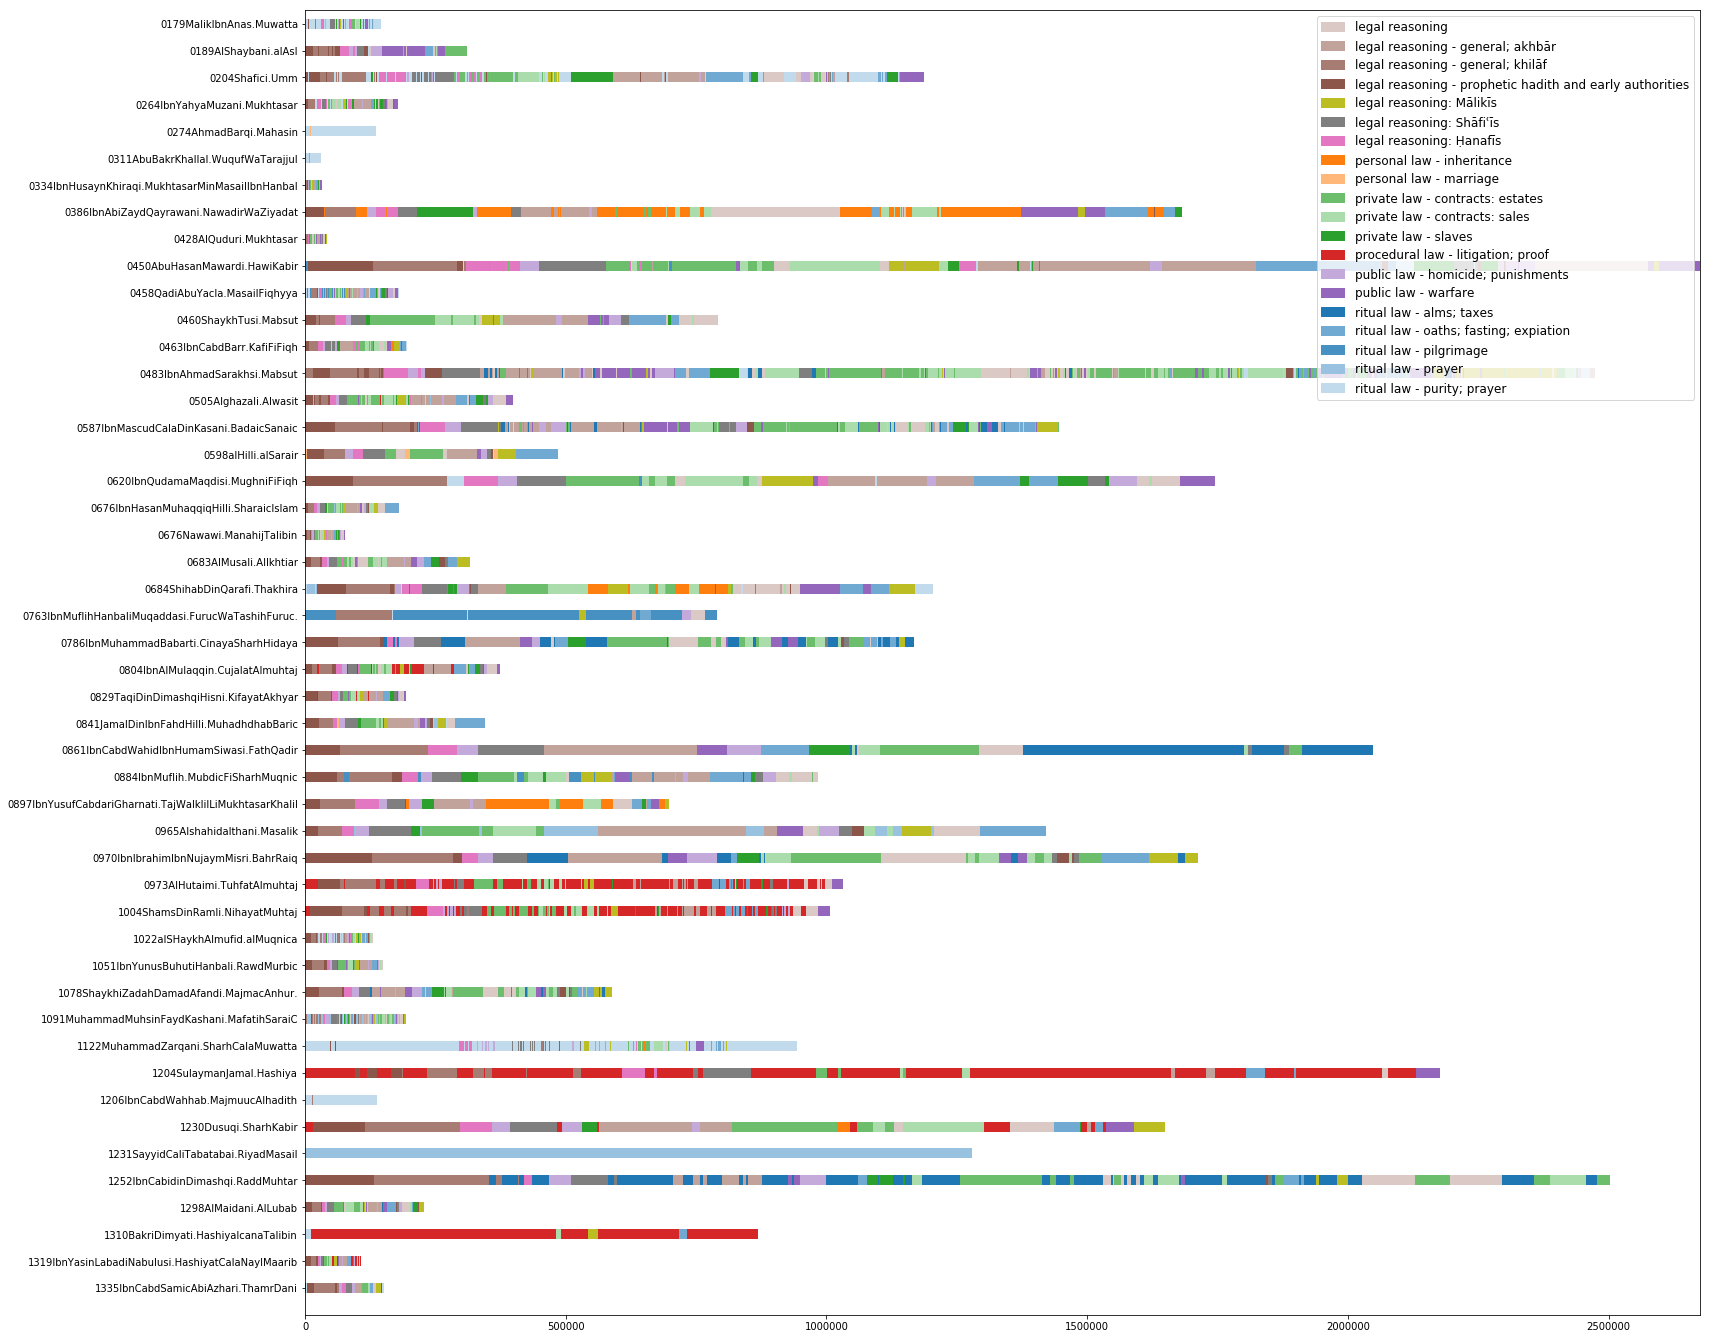

In [37]:
plot_bar_per_book(largest_topics, 'x0', 'x1', book_names, topic_order, legend=True)

Here we look at the distribution of topics per book, shown as percentages of the complete book.

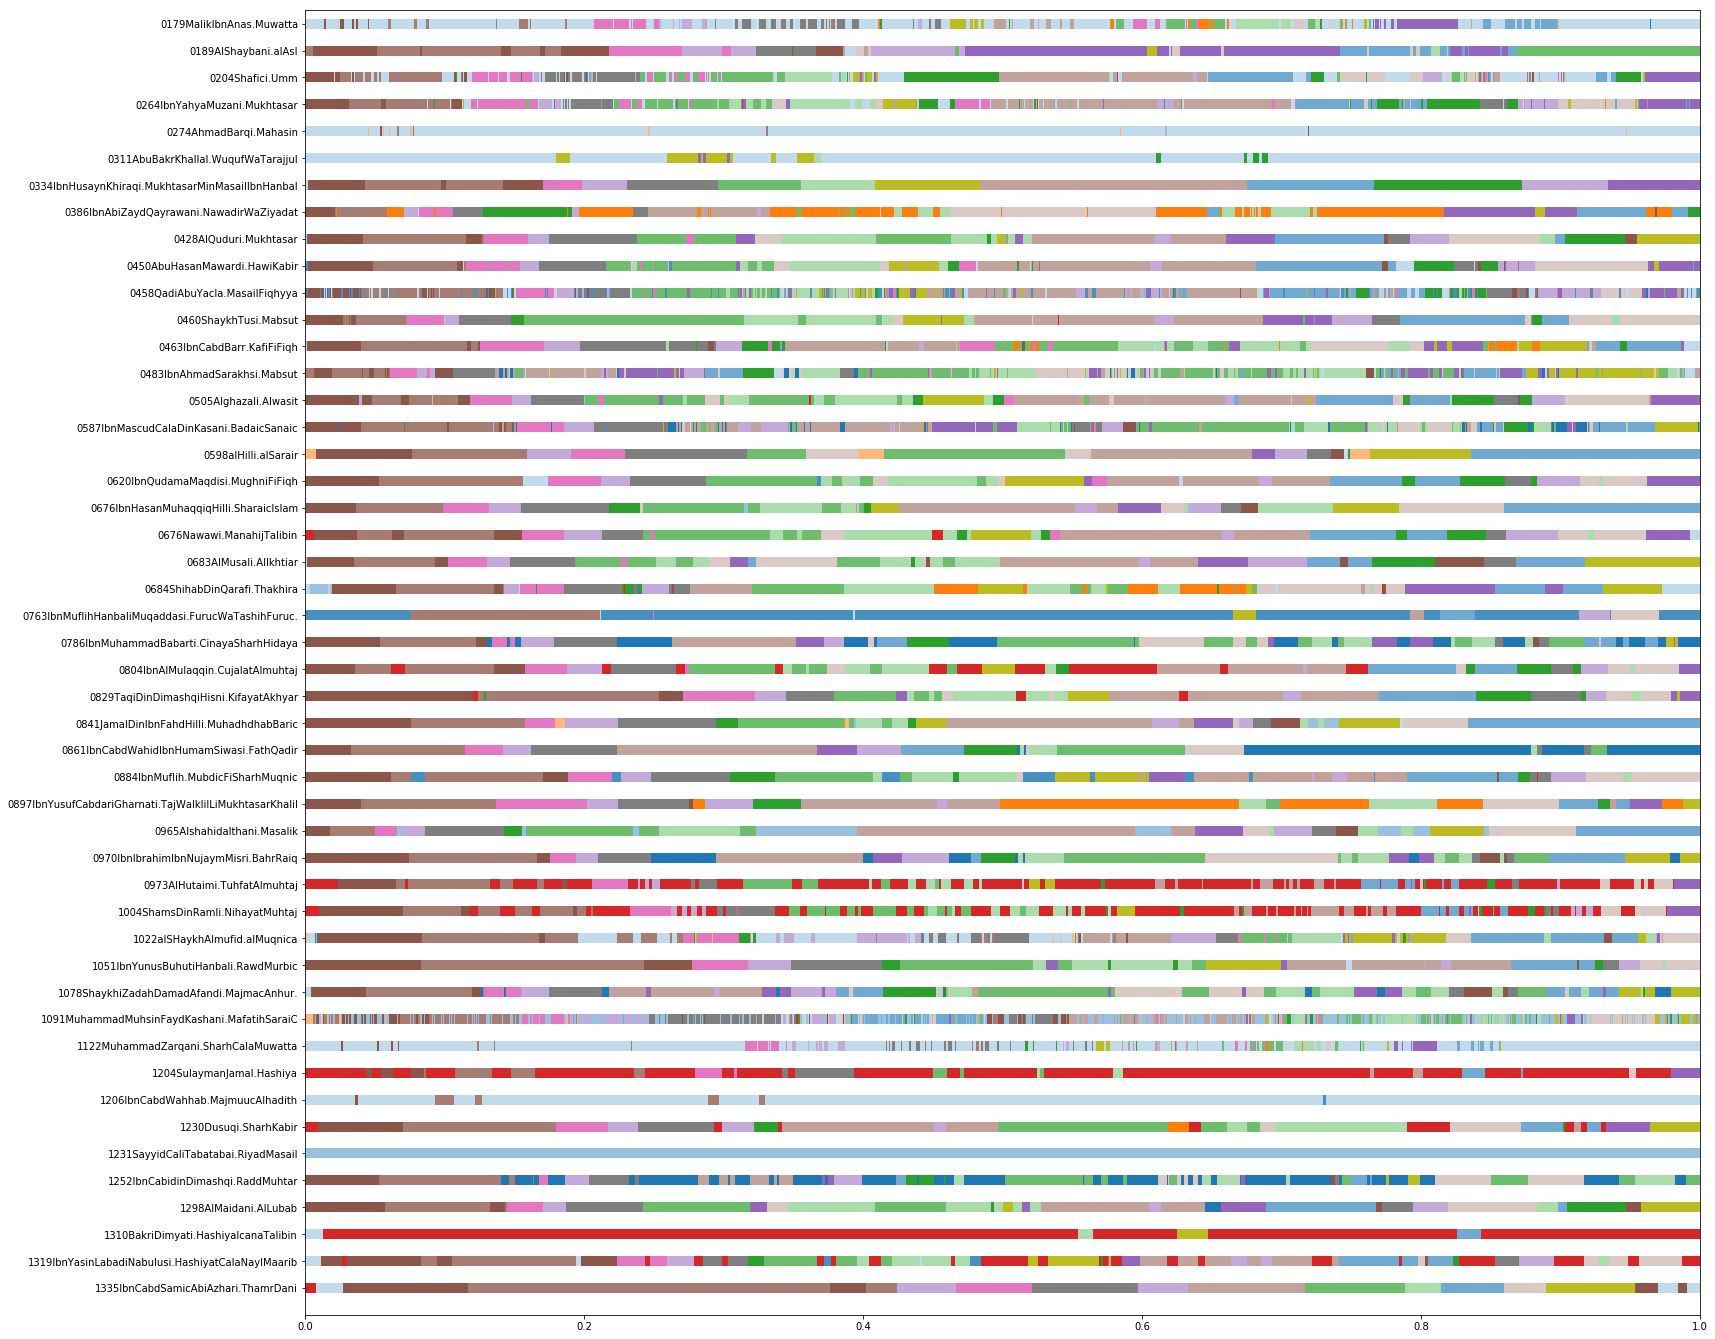

In [38]:
plot_bar_per_book(largest_topics, 'perc0', 'perc1', book_names, topic_names, legend=False)

Here is the same plot, but grouped per school.

مالكي


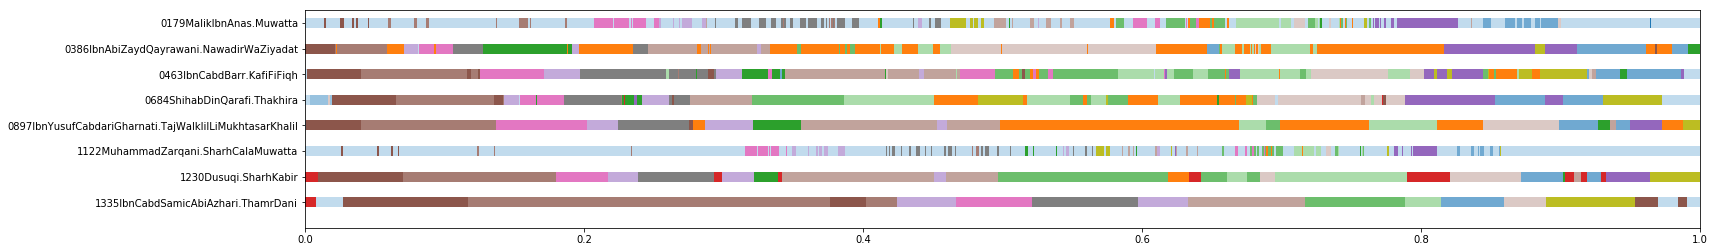

حنفي


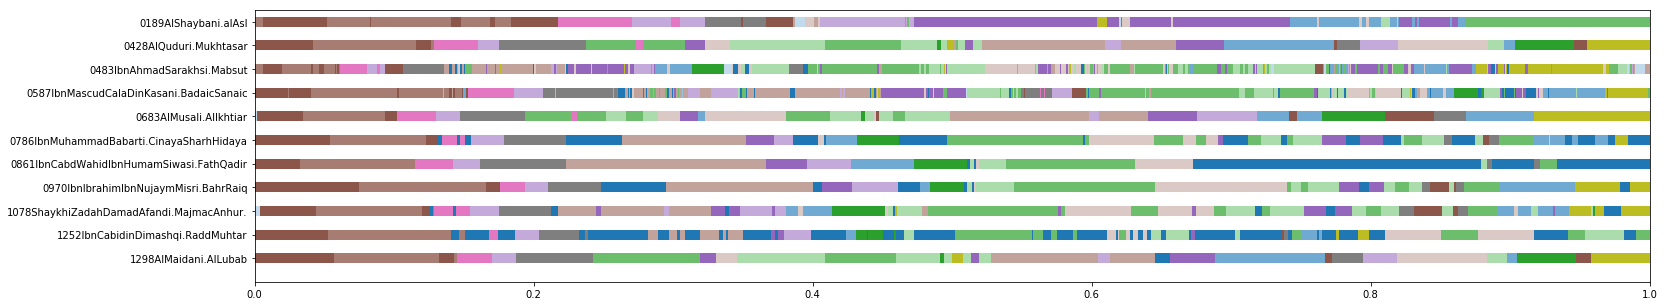

شافعي


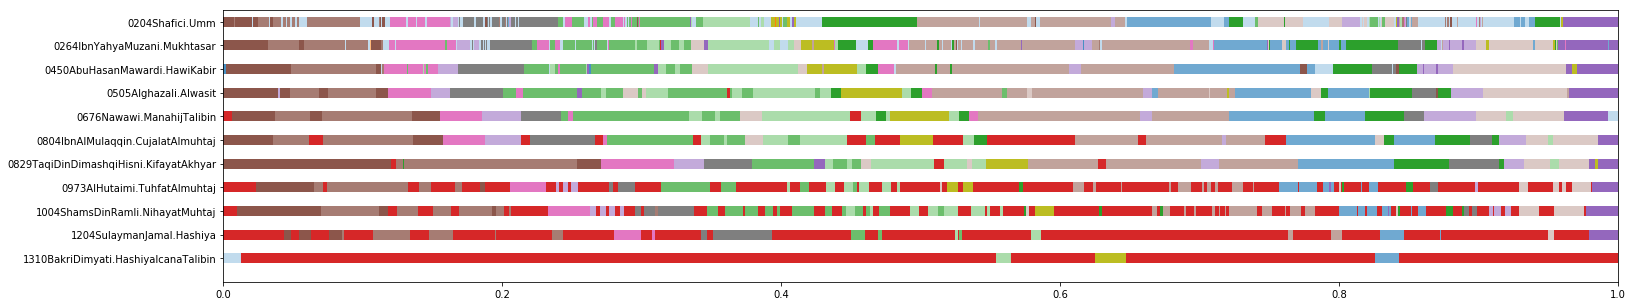

جعفري


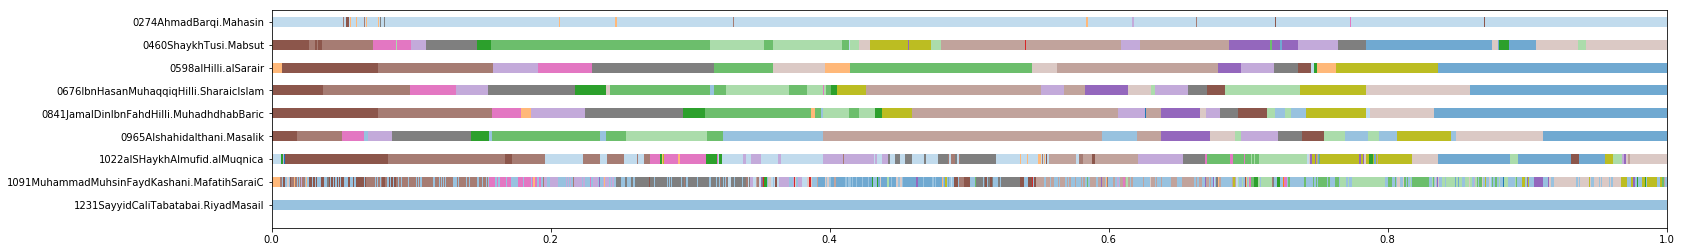

حنبلي


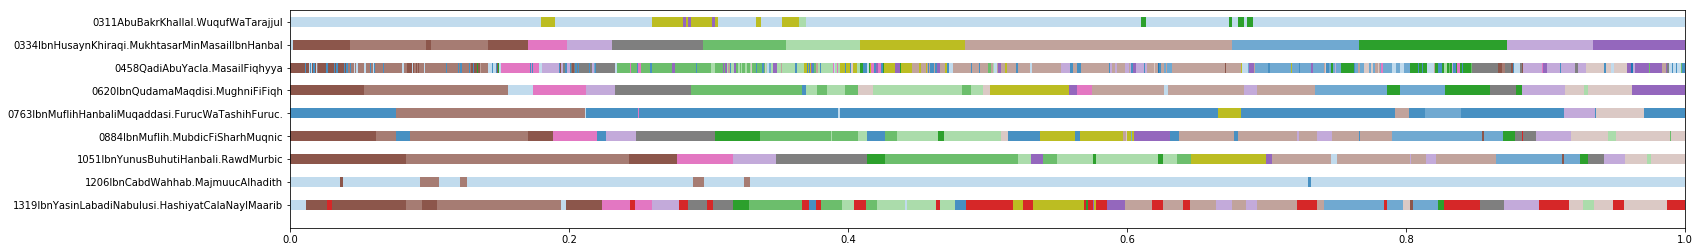

In [39]:
for subj in metadata.BookSUBJ.unique():
    if type(subj)==str:
        print(subj)
        ind_sub = metadata_newind[metadata_newind.BookSUBJ==subj].index.to_frame()
        ind_sub.columns = ['book', 'chapter']
        largest_topics_sub = largest_topics.merge(ind_sub, how='inner')
        plot_bar_per_book(largest_topics_sub, 'perc0', 'perc1', largest_topics_sub.book.unique(), topic_names, legend=False)

Now larger plots for a few selected books:

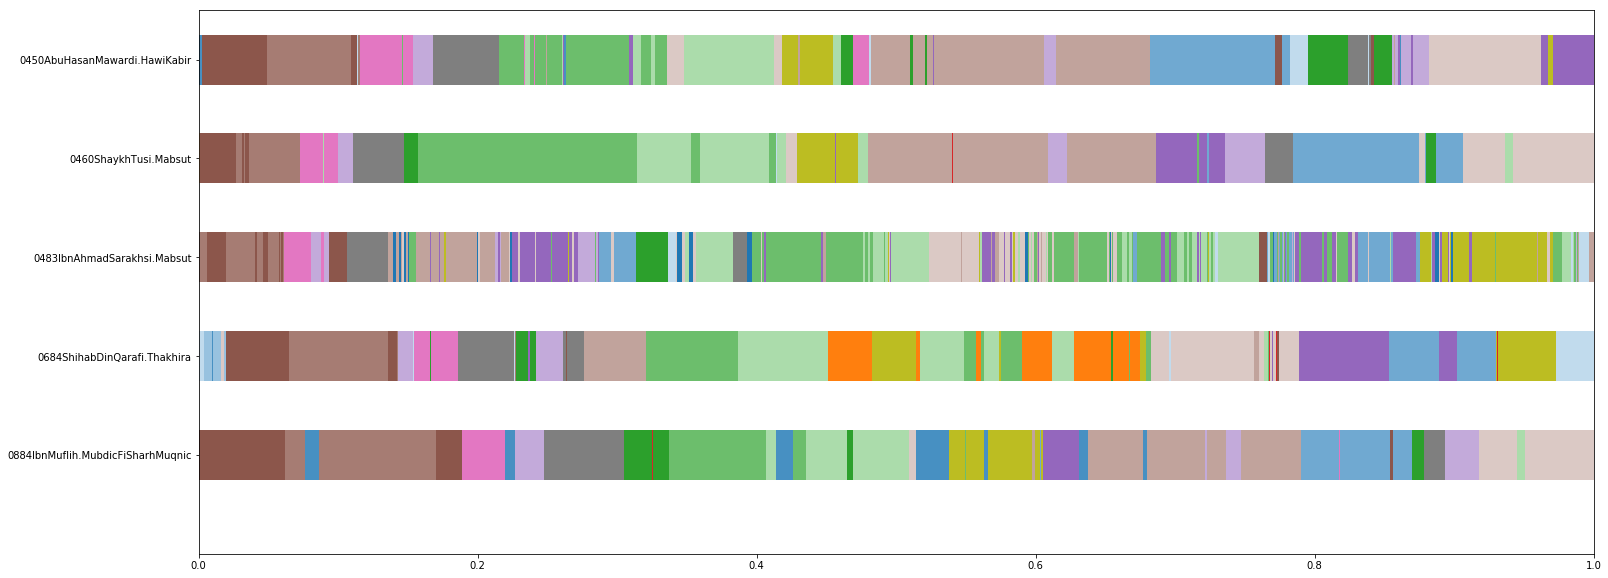

In [40]:
books_of_interest = ['0483IbnAhmadSarakhsi.Mabsut',
                    '0450AbuHasanMawardi.HawiKabir',
                    '0684ShihabDinQarafi.Thakhira',
                    '0884IbnMuflih.MubdicFiSharhMuqnic',
                    '0460ShaykhTusi.Mabsut']
ind_sub = metadata_newind[metadata_newind.BookURI.isin(books_of_interest)].index.to_frame()
ind_sub.columns = ['book', 'chapter']
largest_topics_sub = largest_topics.merge(ind_sub, how='inner')
plot_bar_per_book(largest_topics_sub, 'perc0', 'perc1', largest_topics_sub.book.unique(), topic_names, legend=False, figsize=(25, 10), lw=50)

In [41]:
largest_topics['perc'] = largest_topics.perc1 - largest_topics.perc0

For each topic, what are the books that spent most time on that topic? (as percentage of the complete book). We also show the number of chapters with this topic in this book, because if the book consist of only 1 chapter, the book will have 100% one topic.

In [42]:
from IPython.display import display
for label in topic_names:
    print(label)
    grouped = largest_topics[largest_topics.label==label].groupby('book')
    #print(grouped['length'].aggregate((sum, len)).sort_values('sum', ascending=False)[:10])
    books_per_topic = grouped['perc'].aggregate((sum,len)).sort_values('sum', ascending=False)
    books_per_topic.columns = ['perc', 'nr_chapters_topic']
    books_per_topic['nr_chapters_total'] = largest_topics.groupby('book')['perc'].count()
    books_per_topic['perc'] = books_per_topic.perc.map(lambda x: '{:.1f}%'.format(x*100))
    books_per_topic['nr_chapters_topic'] = books_per_topic.nr_chapters_topic.map(int)
    display(books_per_topic[:10])
    print('\n')

public law - warfare


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0189AlShaybani.alAsl,29.1%,94,242
0483IbnAhmadSarakhsi.Mabsut,11.6%,115,761
0386IbnAbiZaydQayrawani.NawadirWaZiyadat,8.8%,8,199
0684ShihabDinQarafi.Thakhira,8.0%,9,261
0587IbnMascudCalaDinKasani.BadaicSanaic,7.0%,49,841
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,6.6%,1,72
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,5.9%,18,185
0786IbnMuhammadBabarti.CinayaSharhHidaya,5.8%,9,167
0428AlQuduri.Mukhtasar,5.5%,7,119




public law - homicide; punishments


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0189AlShaybani.alAsl,11.2%,24,242
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,9.4%,3,72
1022alSHaykhAlmufid.alMuqnica,8.7%,26,357
1335IbnCabdSamicAbiAzhari.ThamrDani,7.8%,3,36
0458QadiAbuYacla.MasailFiqhyya,7.7%,62,925
0676Nawawi.ManahijTalibin,7.3%,5,108
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,6.8%,6,48
0587IbnMascudCalaDinKasani.BadaicSanaic,6.8%,45,841
0683AlMusali.AlIkhtiar,6.7%,4,116




legal reasoning: Mālikīs


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0483IbnAhmadSarakhsi.Mabsut,8.3%,65,761
0683AlMusali.AlIkhtiar,8.3%,2,116
0684ShihabDinQarafi.Thakhira,8.0%,35,261
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,7.6%,7,72
0598alHilli.alSarair,7.3%,3,32
1022alSHaykhAlmufid.alMuqnica,6.8%,31,357
0676IbnHasanMuhaqqiqHilli.SharaicIslam,6.8%,2,54
0311AbuBakrKhallal.WuqufWaTarajjul,6.6%,11,85
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,6.5%,2,48




ritual law - purity; prayer


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0274AhmadBarqi.Mahasin,98.5%,377,404
1206IbnCabdWahhab.MajmuucAlhadith,96.5%,98,104
0311AbuBakrKhallal.WuqufWaTarajjul,90.8%,66,85
1122MuhammadZarqani.SharhCalaMuwatta,81.7%,409,625
0179MalikIbnAnas.Muwatta,59.9%,431,664
0204Shafici.Umm,21.0%,247,790
1022alSHaykhAlmufid.alMuqnica,18.0%,80,357
0458QadiAbuYacla.MasailFiqhyya,5.9%,41,925
0264IbnYahyaMuzani.Mukhtasar,5.5%,45,481




private law - contracts: sales


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0483IbnAhmadSarakhsi.Mabsut,13.8%,112,761
1298AlMaidani.AlLubab,13.0%,13,124
0684ShihabDinQarafi.Thakhira,12.4%,18,261
0428AlQuduri.Mukhtasar,12.1%,12,119
0676IbnHasanMuhaqqiqHilli.SharaicIslam,11.5%,14,54
0463IbnCabdBarr.KafiFiFiqh,11.4%,39,351
0460ShaykhTusi.Mabsut,10.9%,16,225
1230Dusuqi.SharhKabir,10.9%,10,61
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,10.4%,18,185




ritual law - prayer


,perc,nr_chapters_topic,nr_chapters_total
book,,,
1231SayyidCaliTabatabai.RiyadMasail,100.0%,23,24
1091MuhammadMuhsinFaydKashani.MafatihSaraiC,32.0%,408,1247
0965Alshahidalthani.Masalik,14.0%,13,57
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,2.0%,3,48
0684ShihabDinQarafi.Thakhira,1.4%,18,261
0676IbnHasanMuhaqqiqHilli.SharaicIslam,0.3%,1,54
0897IbnYusufCabdariGharnati.TajWaIklilLiMukhtasarKhalil,0.0%,1,64
0505Alghazali.Alwasit,0.0%,2,250
0587IbnMascudCalaDinKasani.BadaicSanaic,0.0%,1,841




personal law - marriage


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0598alHilli.alSarair,4.0%,4,32
1091MuhammadMuhsinFaydKashani.MafatihSaraiC,1.2%,13,1247
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,1.0%,2,48
1022alSHaykhAlmufid.alMuqnica,0.7%,8,357
0274AhmadBarqi.Mahasin,0.6%,12,404
0460ShaykhTusi.Mabsut,0.1%,1,225
0505Alghazali.Alwasit,0.0%,3,250
1231SayyidCaliTabatabai.RiyadMasail,0.0%,1,24
0264IbnYahyaMuzani.Mukhtasar,0.0%,1,481




ritual law - pilgrimage


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFuruc.,75.2%,23,41
0458QadiAbuYacla.MasailFiqhyya,8.2%,111,925
0884IbnMuflih.MubdicFiSharhMuqnic,6.6%,12,316
1319IbnYasinLabadiNabulusi.HashiyatCalaNaylMaarib,1.3%,2,140
0450AbuHasanMawardi.HawiKabir,0.4%,5,250
0620IbnQudamaMaqdisi.MughniFiFiqh,0.3%,1,71
1206IbnCabdWahhab.MajmuucAlhadith,0.2%,1,104
0264IbnYahyaMuzani.Mukhtasar,0.1%,1,481
0684ShihabDinQarafi.Thakhira,0.0%,1,261




procedural law - litigation; proof


,perc,nr_chapters_topic,nr_chapters_total
book,,,
1310BakriDimyati.HashiyaIcanaTalibin,93.8%,18,22
1204SulaymanJamal.Hashiya,77.6%,74,125
0973AlHutaimi.TuhfatAlmuhtaj,58.0%,158,276
1004ShamsDinRamli.NihayatMuhtaj,40.9%,127,327
1319IbnYasinLabadiNabulusi.HashiyatCalaNaylMaarib,19.0%,27,140
0804IbnAlMulaqqin.CujalatAlmuhtaj,16.5%,13,121
1230Dusuqi.SharhKabir,7.0%,13,61
0829TaqiDinDimashqiHisni.KifayatAkhyar,1.7%,4,150
0676Nawawi.ManahijTalibin,1.4%,2,108




legal reasoning: Ḥanafīs


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0264IbnYahyaMuzani.Mukhtasar,8.7%,39,481
0463IbnCabdBarr.KafiFiFiqh,8.1%,25,351
0897IbnYusufCabdariGharnati.TajWaIklilLiMukhtasarKhalil,6.5%,1,64
0204Shafici.Umm,6.1%,115,790
0189AlShaybani.alAsl,5.9%,8,242
1335IbnCabdSamicAbiAzhari.ThamrDani,5.4%,3,36
0179MalikIbnAnas.Muwatta,5.3%,25,664
0829TaqiDinDimashqiHisni.KifayatAkhyar,5.2%,5,150
0450AbuHasanMawardi.HawiKabir,5.0%,28,250




ritual law - alms; taxes


,perc,nr_chapters_topic,nr_chapters_total
book,,,
1252IbnCabidinDimashqi.RaddMuhtar,38.0%,90,227
0861IbnCabdWahidIbnHumamSiwasi.FathQadir,30.6%,27,57
0786IbnMuhammadBabarti.CinayaSharhHidaya,20.3%,28,167
0970IbnIbrahimIbnNujaymMisri.BahrRaiq,8.7%,8,59
0587IbnMascudCalaDinKasani.BadaicSanaic,5.0%,66,841
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,3.6%,8,185
0483IbnAhmadSarakhsi.Mabsut,2.7%,22,761
1298AlMaidani.AlLubab,1.1%,1,124
0458QadiAbuYacla.MasailFiqhyya,0.2%,2,925




legal reasoning


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0386IbnAbiZaydQayrawani.NawadirWaZiyadat,14.7%,12,199
0460ShaykhTusi.Mabsut,10.0%,12,225
0450AbuHasanMawardi.HawiKabir,9.9%,8,250
1252IbnCabidinDimashqi.RaddMuhtar,9.7%,17,227
0684ShihabDinQarafi.Thakhira,9.7%,41,261
0970IbnIbrahimIbnNujaymMisri.BahrRaiq,9.6%,5,59
0676IbnHasanMuhaqqiqHilli.SharaicIslam,9.4%,4,54
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,9.3%,15,185
0483IbnAhmadSarakhsi.Mabsut,8.5%,85,761




legal reasoning: Shāfiʿīs


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0598alHilli.alSarair,10.5%,2,32
1091MuhammadMuhsinFaydKashani.MafatihSaraiC,9.6%,121,1247
0463IbnCabdBarr.KafiFiFiqh,9.0%,32,351
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,8.3%,2,48
0428AlQuduri.Mukhtasar,7.9%,9,119
1298AlMaidani.AlLubab,7.7%,9,124
1051IbnYunusBuhutiHanbali.RawdMurbic,7.7%,14,143
0676IbnHasanMuhaqqiqHilli.SharaicIslam,7.7%,3,54
1335IbnCabdSamicAbiAzhari.ThamrDani,7.6%,2,36




legal reasoning - general; akhbār


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0965Alshahidalthani.Masalik,21.7%,6,57
0505Alghazali.Alwasit,19.9%,43,250
0460ShaykhTusi.Mabsut,19.3%,37,225
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,19.1%,9,72
0450AbuHasanMawardi.HawiKabir,19.0%,43,250
0264IbnYahyaMuzani.Mukhtasar,18.8%,86,481
0458QadiAbuYacla.MasailFiqhyya,18.3%,132,925
0829TaqiDinDimashqiHisni.KifayatAkhyar,17.4%,20,150
0676Nawawi.ManahijTalibin,17.1%,12,108




legal reasoning - general; khilāf


,perc,nr_chapters_topic,nr_chapters_total
book,,,
1335IbnCabdSamicAbiAzhari.ThamrDani,28.2%,6,36
1051IbnYunusBuhutiHanbali.RawdMurbic,16.0%,12,143
1022alSHaykhAlmufid.alMuqnica,14.5%,32,357
0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFuruc.,13.5%,1,41
0829TaqiDinDimashqiHisni.KifayatAkhyar,12.9%,19,150
0189AlShaybani.alAsl,12.6%,30,242
1230Dusuqi.SharhKabir,11.0%,1,61
0620IbnQudamaMaqdisi.MughniFiFiqh,10.4%,5,71
1004ShamsDinRamli.NihayatMuhtaj,10.3%,19,327




private law - contracts: estates


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0483IbnAhmadSarakhsi.Mabsut,19.4%,149,761
0786IbnMuhammadBabarti.CinayaSharhHidaya,18.1%,27,167
0598alHilli.alSarair,17.2%,2,32
0460ShaykhTusi.Mabsut,17.0%,5,225
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,16.1%,24,185
0587IbnMascudCalaDinKasani.BadaicSanaic,16.1%,89,841
1230Dusuqi.SharhKabir,15.1%,7,61
0970IbnIbrahimIbnNujaymMisri.BahrRaiq,14.3%,8,59
0505Alghazali.Alwasit,13.7%,33,250




legal reasoning - prophetic hadith and early authorities


,perc,nr_chapters_topic,nr_chapters_total
book,,,
1335IbnCabdSamicAbiAzhari.ThamrDani,13.8%,11,36
0829TaqiDinDimashqiHisni.KifayatAkhyar,13.7%,13,150
1051IbnYunusBuhutiHanbali.RawdMurbic,11.9%,13,143
0189AlShaybani.alAsl,11.2%,24,242
1319IbnYasinLabadiNabulusi.HashiyatCalaNaylMaarib,10.6%,13,140
0970IbnIbrahimIbnNujaymMisri.BahrRaiq,10.0%,4,59
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,9.7%,2,48
1022alSHaykhAlmufid.alMuqnica,8.7%,17,357
0683AlMusali.AlIkhtiar,8.6%,11,116




personal law - inheritance


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0386IbnAbiZaydQayrawani.NawadirWaZiyadat,32.4%,91,199
0897IbnYusufCabdariGharnati.TajWaIklilLiMukhtasarKhalil,29.1%,19,64
0684ShihabDinQarafi.Thakhira,10.5%,11,261
0463IbnCabdBarr.KafiFiFiqh,3.3%,10,351
0179MalikIbnAnas.Muwatta,1.9%,12,664
1230Dusuqi.SharhKabir,1.5%,1,61
1122MuhammadZarqani.SharhCalaMuwatta,0.3%,5,625
1091MuhammadMuhsinFaydKashani.MafatihSaraiC,0.0%,1,1247
0204Shafici.Umm,0.0%,2,790




ritual law - oaths; fasting; expiation


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,16.7%,3,48
0598alHilli.alSarair,16.4%,2,32
0676IbnHasanMuhaqqiqHilli.SharaicIslam,14.1%,3,54
0460ShaykhTusi.Mabsut,11.1%,17,225
1022alSHaykhAlmufid.alMuqnica,11.0%,25,357
0683AlMusali.AlIkhtiar,9.6%,8,116
0450AbuHasanMawardi.HawiKabir,9.6%,10,250
0804IbnAlMulaqqin.CujalatAlmuhtaj,9.3%,10,121
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,9.1%,5,72




private law - slaves


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,10.6%,1,72
0204Shafici.Umm,9.8%,19,790
0264IbnYahyaMuzani.Mukhtasar,8.5%,36,481
0386IbnAbiZaydQayrawani.NawadirWaZiyadat,7.2%,10,199
0505Alghazali.Alwasit,5.8%,13,250
0450AbuHasanMawardi.HawiKabir,5.2%,10,250
0676Nawawi.ManahijTalibin,5.0%,7,108
0683AlMusali.AlIkhtiar,4.8%,2,116
0804IbnAlMulaqqin.CujalatAlmuhtaj,4.7%,7,121


In [43]:
# Same thing but for level 1 topic
for label in largest_topics.topic_level1.unique():
    print(label)
    grouped = largest_topics[largest_topics.topic_level1==label].groupby('book')
    #print(grouped['length'].aggregate((sum, len)).sort_values('sum', ascending=False)[:10])
    books_per_topic = grouped['perc'].aggregate((sum,len)).sort_values('sum', ascending=False)
    books_per_topic.columns = ['perc', 'nr_chapters_topic']
    books_per_topic['nr_chapters_total'] = largest_topics.groupby('book')['perc'].count()
    books_per_topic['perc'] = books_per_topic.perc.map(lambda x: '{:.1f}%'.format(x*100))
    books_per_topic['nr_chapters_topic'] = books_per_topic.nr_chapters_topic.map(int)
    display(books_per_topic[:10])
    print('\n')

legal reasoning: Ḥanafīs


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0264IbnYahyaMuzani.Mukhtasar,8.7%,39,481
0463IbnCabdBarr.KafiFiFiqh,8.1%,25,351
0897IbnYusufCabdariGharnati.TajWaIklilLiMukhtasarKhalil,6.5%,1,64
0204Shafici.Umm,6.1%,115,790
0189AlShaybani.alAsl,5.9%,8,242
1335IbnCabdSamicAbiAzhari.ThamrDani,5.4%,3,36
0179MalikIbnAnas.Muwatta,5.3%,25,664
0829TaqiDinDimashqiHisni.KifayatAkhyar,5.2%,5,150
0450AbuHasanMawardi.HawiKabir,5.0%,28,250




ritual law


,perc,nr_chapters_topic,nr_chapters_total
book,,,
1231SayyidCaliTabatabai.RiyadMasail,100.0%,23,24
0274AhmadBarqi.Mahasin,98.5%,377,404
1206IbnCabdWahhab.MajmuucAlhadith,96.7%,99,104
0311AbuBakrKhallal.WuqufWaTarajjul,90.8%,66,85
1122MuhammadZarqani.SharhCalaMuwatta,82.9%,428,625
0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFuruc.,78.0%,30,41
0179MalikIbnAnas.Muwatta,63.5%,453,664
1252IbnCabidinDimashqi.RaddMuhtar,40.0%,98,227
1091MuhammadMuhsinFaydKashani.MafatihSaraiC,39.9%,498,1247




legal reasoning


,perc,nr_chapters_topic,nr_chapters_total
book,,,
1335IbnCabdSamicAbiAzhari.ThamrDani,53.5%,20,36
0829TaqiDinDimashqiHisni.KifayatAkhyar,49.2%,61,150
1051IbnYunusBuhutiHanbali.RawdMurbic,46.6%,55,143
0450AbuHasanMawardi.HawiKabir,40.9%,71,250
0884IbnMuflih.MubdicFiSharhMuqnic,40.2%,109,316
0505Alghazali.Alwasit,40.1%,102,250
0676Nawawi.ManahijTalibin,39.4%,38,108
0970IbnIbrahimIbnNujaymMisri.BahrRaiq,39.3%,12,59
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,38.7%,10,48




personal law


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0386IbnAbiZaydQayrawani.NawadirWaZiyadat,32.4%,91,199
0897IbnYusufCabdariGharnati.TajWaIklilLiMukhtasarKhalil,29.1%,19,64
0684ShihabDinQarafi.Thakhira,10.5%,12,261
0598alHilli.alSarair,4.0%,4,32
0463IbnCabdBarr.KafiFiFiqh,3.3%,10,351
0179MalikIbnAnas.Muwatta,1.9%,12,664
1230Dusuqi.SharhKabir,1.5%,1,61
1091MuhammadMuhsinFaydKashani.MafatihSaraiC,1.3%,14,1247
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,1.0%,2,48




public law


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0189AlShaybani.alAsl,40.3%,118,242
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,16.0%,4,72
0483IbnAhmadSarakhsi.Mabsut,14.7%,142,761
0587IbnMascudCalaDinKasani.BadaicSanaic,13.8%,94,841
0458QadiAbuYacla.MasailFiqhyya,12.6%,102,925
0683AlMusali.AlIkhtiar,11.5%,11,116
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,11.3%,27,185
0684ShihabDinQarafi.Thakhira,11.0%,24,261
0428AlQuduri.Mukhtasar,10.8%,11,119




legal reasoning: Shāfiʿīs


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0598alHilli.alSarair,10.5%,2,32
1091MuhammadMuhsinFaydKashani.MafatihSaraiC,9.6%,121,1247
0463IbnCabdBarr.KafiFiFiqh,9.0%,32,351
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,8.3%,2,48
0428AlQuduri.Mukhtasar,7.9%,9,119
1298AlMaidani.AlLubab,7.7%,9,124
1051IbnYunusBuhutiHanbali.RawdMurbic,7.7%,14,143
0676IbnHasanMuhaqqiqHilli.SharaicIslam,7.7%,3,54
1335IbnCabdSamicAbiAzhari.ThamrDani,7.6%,2,36




private law


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0483IbnAhmadSarakhsi.Mabsut,35.6%,273,761
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,30.5%,50,185
1298AlMaidani.AlLubab,30.3%,32,124
0460ShaykhTusi.Mabsut,29.6%,30,225
0428AlQuduri.Mukhtasar,28.7%,31,119
0505Alghazali.Alwasit,28.2%,79,250
1230Dusuqi.SharhKabir,27.8%,19,61
0587IbnMascudCalaDinKasani.BadaicSanaic,27.2%,191,841
0786IbnMuhammadBabarti.CinayaSharhHidaya,27.0%,46,167




legal reasoning: Mālikīs


,perc,nr_chapters_topic,nr_chapters_total
book,,,
0483IbnAhmadSarakhsi.Mabsut,8.3%,65,761
0683AlMusali.AlIkhtiar,8.3%,2,116
0684ShihabDinQarafi.Thakhira,8.0%,35,261
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,7.6%,7,72
0598alHilli.alSarair,7.3%,3,32
1022alSHaykhAlmufid.alMuqnica,6.8%,31,357
0676IbnHasanMuhaqqiqHilli.SharaicIslam,6.8%,2,54
0311AbuBakrKhallal.WuqufWaTarajjul,6.6%,11,85
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,6.5%,2,48




procedural law


,perc,nr_chapters_topic,nr_chapters_total
book,,,
1310BakriDimyati.HashiyaIcanaTalibin,93.8%,18,22
1204SulaymanJamal.Hashiya,77.6%,74,125
0973AlHutaimi.TuhfatAlmuhtaj,58.0%,158,276
1004ShamsDinRamli.NihayatMuhtaj,40.9%,127,327
1319IbnYasinLabadiNabulusi.HashiyatCalaNaylMaarib,19.0%,27,140
0804IbnAlMulaqqin.CujalatAlmuhtaj,16.5%,13,121
1230Dusuqi.SharhKabir,7.0%,13,61
0829TaqiDinDimashqiHisni.KifayatAkhyar,1.7%,4,150
0676Nawawi.ManahijTalibin,1.4%,2,108


## Barplots

In [44]:
def plot_bars_values(values, topic_names, color_dict, reshape_col1=False, topic_order=None):
    plt.figure(figsize=(15,10))
    ax = plt.gca()
    values = values.unstack().fillna(0)   
    values = values.reindex(sorted(values.index), axis=0)
    #sorted_index = values.sum(axis=1).sort_values(ascending=False).index
    #values = values.loc[sorted_index,:]
    ind0 = values.index
    if topic_order is not None:
        values = values[topic_order]
    ind1 = values.columns
    x = np.arange(len(ind0))
    last_y = np.repeat(0, len(ind0))
    for t, topic_name in enumerate(ind1):
        y = values[topic_name]
        if topic_name != 'noise':
            ax.bar(x, y, bottom=last_y, color=color_dict[topic_name],
                    label=bidi.algorithm.get_display(arabic_reshaper.reshape(topic_name)))
            last_y = last_y+y
    if reshape_col1:
        xlabels = [bidi.algorithm.get_display(arabic_reshaper.reshape(l)) for l in ind0]
    else:
        xlabels = ind0
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=90)
    handles, labels = ax.get_legend_handles_labels()
    if topic_order is None:
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

def plot_bars_per_topic(df, topic_names, color_dict, col1, col2='ChapterLength', aggfunc=sum, reshape_col1=False, topic_order=None):
    values = df.groupby([col1, 'topic_name'])[col2].apply(aggfunc).sort_values()
    plot_bars_values(values, topic_names, color_dict, reshape_col1=reshape_col1, topic_order=topic_order)

Here we see the total number of tokens in the corpus per topic, grouped by school.

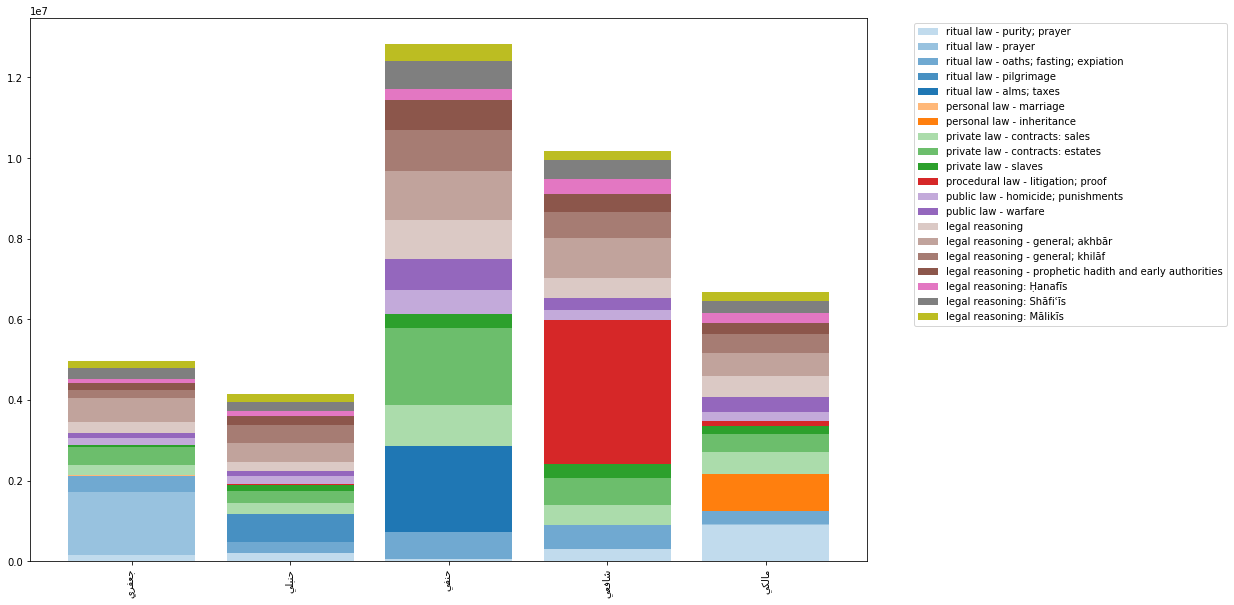

In [45]:
plot_bars_per_topic(metadata_newind, topic_names, color_dict, 'BookSUBJ', reshape_col1=True, topic_order=topic_order)

Now normalized by total number tokens per school:

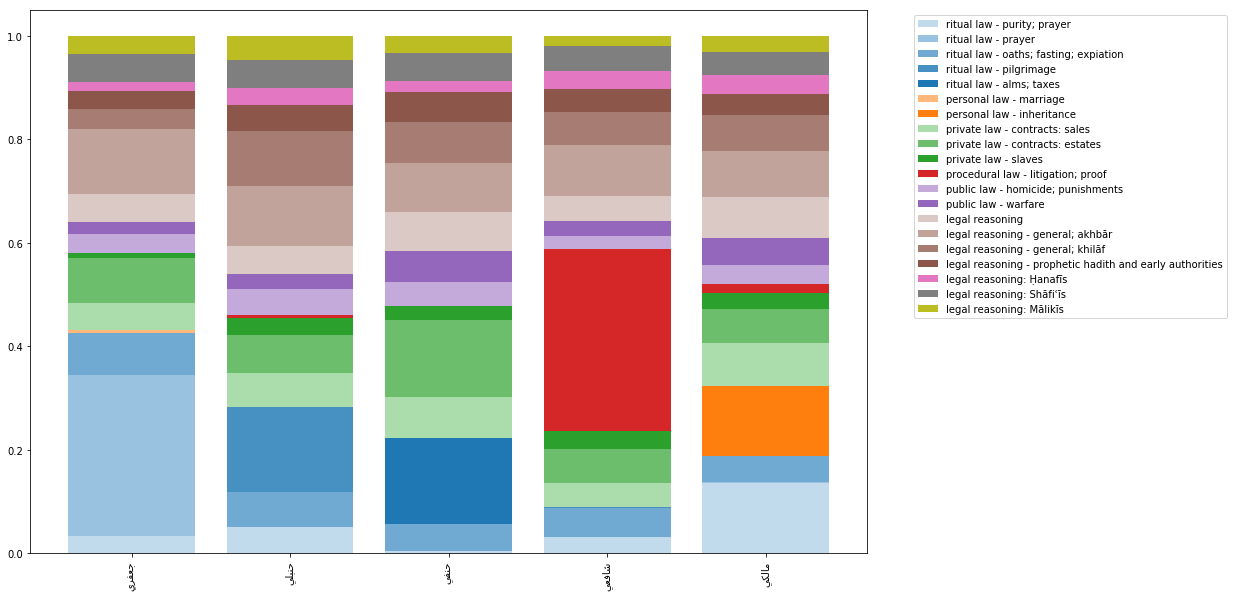

In [46]:
col1= 'BookSUBJ'
col2 = 'ChapterLength'
df = metadata_newind
nr_tokens_per_school = df.groupby([col1])[col2].sum()
rel_topic_per_school = df.groupby([col1, 'topic_name'])[col2].sum().sort_values() / nr_tokens_per_school
plot_bars_values(rel_topic_per_school, topic_names, color_dict,  reshape_col1=True, topic_order=topic_order)

This is only the number the chapters (so not normalized by chapter length).

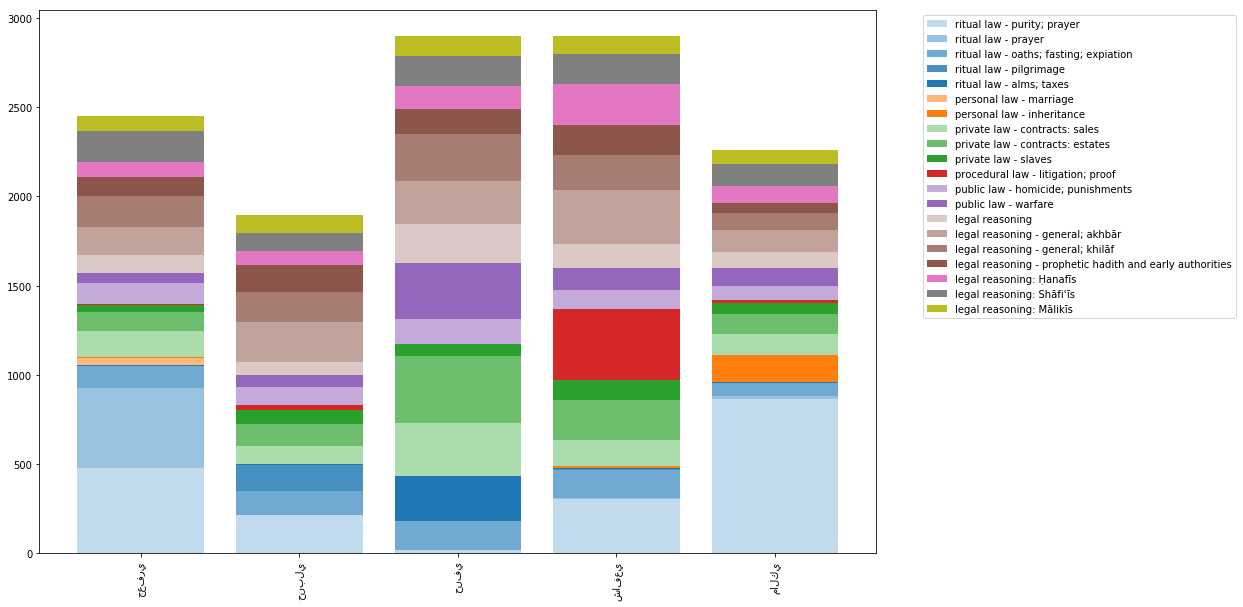

In [47]:
# Here we see only the number of chapters
plot_bars_per_topic(metadata_newind, topic_names, color_dict,  'BookSUBJ', aggfunc=len, topic_order=topic_order)

This is the number of tokens per topic, per geographica area

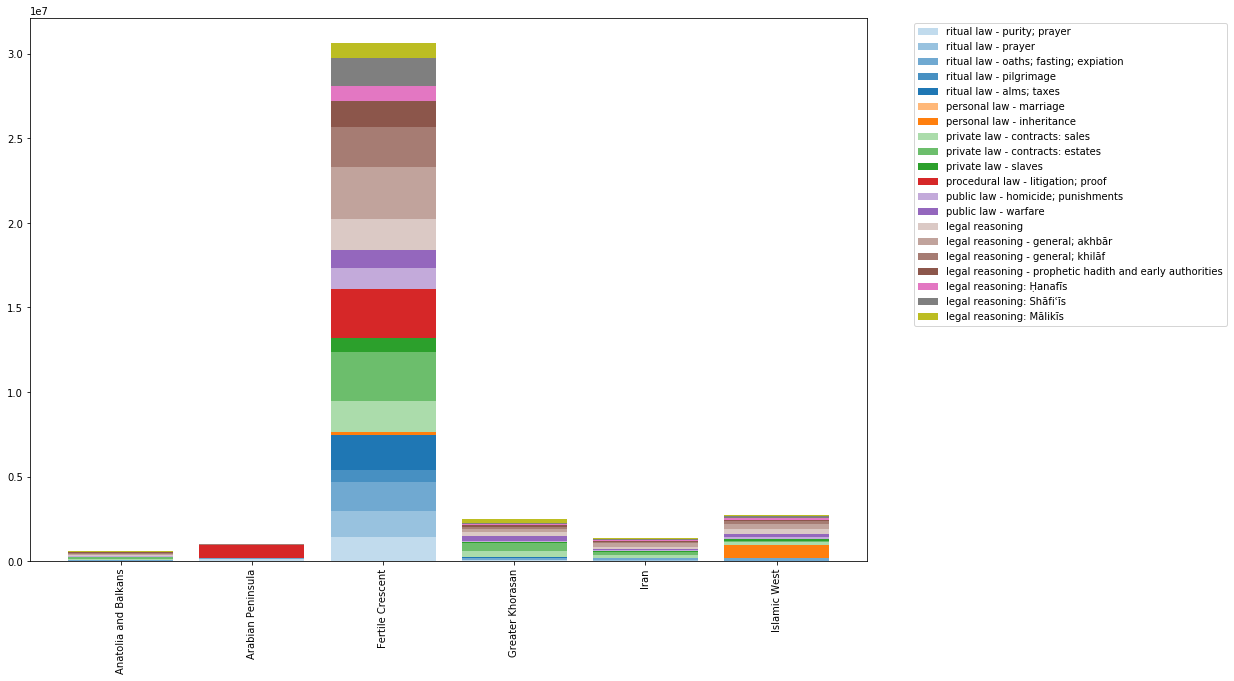

In [48]:
plot_bars_per_topic(metadata_newind, topic_names, color_dict,  'Author_Geographical_Area', topic_order=topic_order)

In [49]:
import re
metadata_newind['Century_num'] = metadata_newind.Century.apply(lambda s: int(re.match('^[0-9]*', s).group(0)))

And the number of tokens per topic, per century

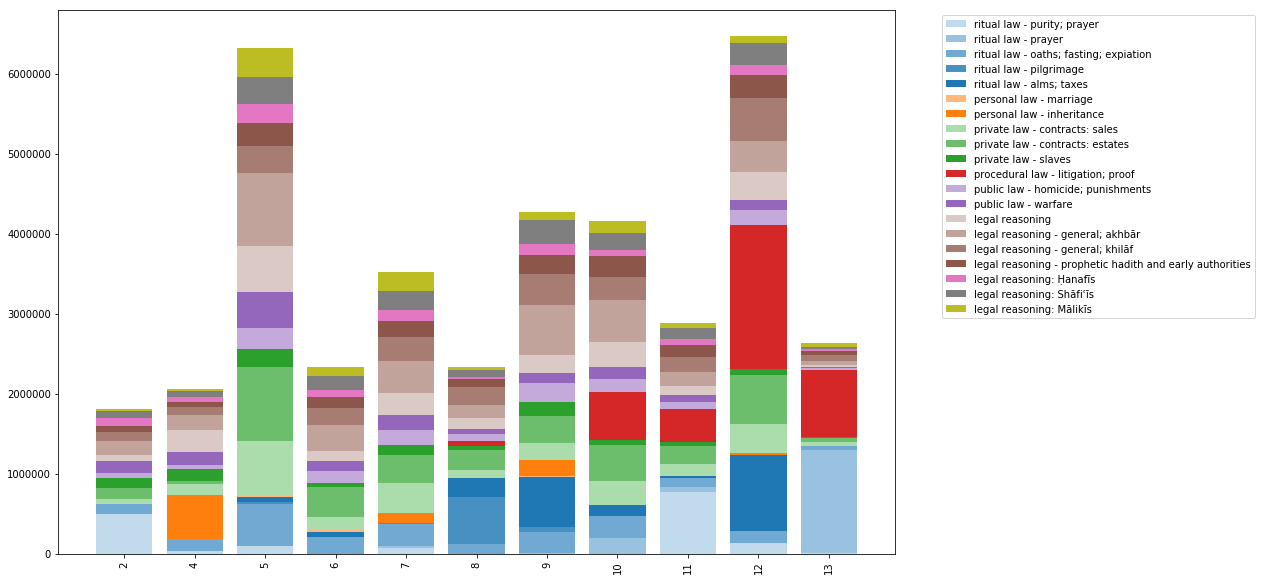

In [50]:
plot_bars_per_topic(metadata_newind, topic_names, color_dict,  'Century_num', topic_order=topic_order)

Now normalized by the total number of tokens per century:

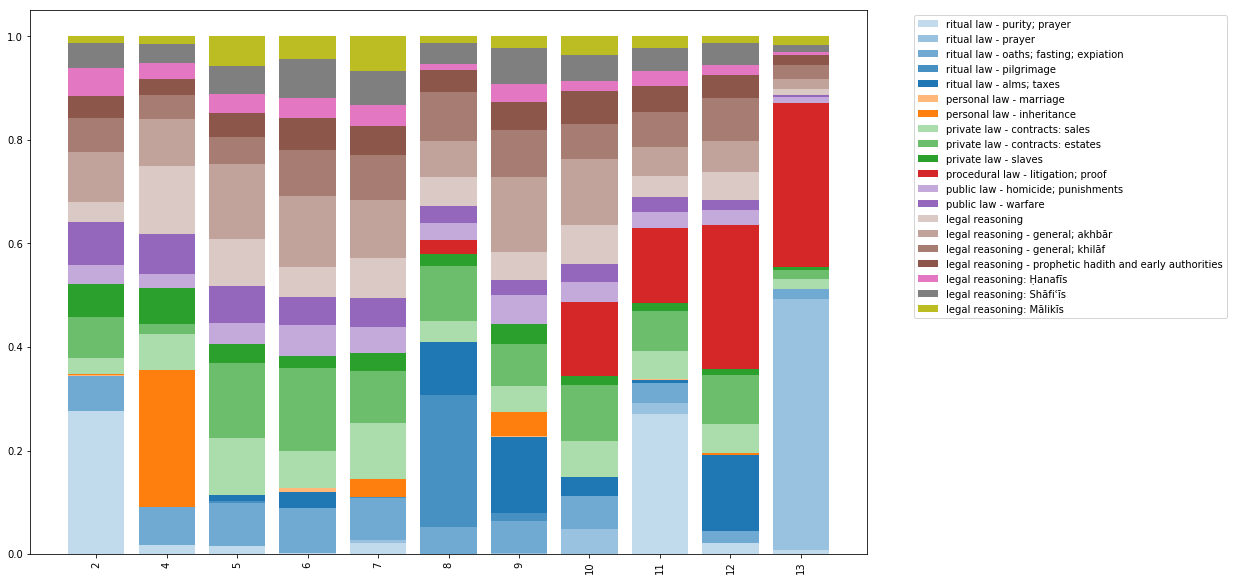

In [51]:
col1= 'Century_num'
col2 = 'ChapterLength'
df = metadata_newind
nr_tokens_per_century = df.groupby([col1])[col2].sum()
rel_topic_per_century = df.groupby([col1, 'topic_name'])[col2].sum().sort_values() / nr_tokens_per_century
plot_bars_values(rel_topic_per_century, topic_names, color_dict,  reshape_col1=False, topic_order=topic_order)

## Volume and chapter titles

In [52]:
def style_color(df, color):
    st = 'background-color: {}'.format(color)
    return df.style.apply(lambda r: [st]*len(r))

# Print the most common titles per topic
for t, topic_name in enumerate(topic_names):
    #if topic_name != 'noise':
    meta_sub = metadata_newind[metadata_newind['topic_name']==topic_name]
    color = matplotlib.colors.to_hex(color_dict[topic_name])
    #print(t, topic_name)
    display(style_color(pd.DataFrame([topic_name], index=[t], columns=['label']), color=color))
    print("Volumes:")
    vol_counts = pd.DataFrame(meta_sub.groupby('Level1Title')['BookURI'].nunique().sort_values(ascending=False))
    vol_counts.columns = ['nr_books']
    display(vol_counts[vol_counts['nr_books']>1].head(10))
    
    print("\nChapters:")
    chapter_counts = pd.DataFrame(meta_sub.groupby('Level2Title')[['BookURI', 'Level1Title']].nunique())
    chapter_counts.columns = ['nr_books', 'nr_volnames']
    chapter_counts['total_count'] = meta_sub.Level2Title.value_counts()
    display(chapter_counts[chapter_counts['nr_volnames']>1].sort_values('nr_books', ascending=False).head())
    print('\n')

,label
0,public law - warfare


Volumes:


,nr_books
Level1Title,
كتاب العتق,15
كتاب المكاتب,11
كتاب الولاء,8
كتاب المأذون,6
كتاب التدبير,6
كتاب الحجر,5
-,5
كتاب الوصايا,3
كتاب,3



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,8,16,23
باب التدبير,8,5,10
باب الاستيلاد,5,5,11
باب,3,5,8
باب الحجر,3,3,3


,label
1,public law - homicide; punishments


Volumes:


,nr_books
Level1Title,
كتاب الأيمان,16
كتاب الصوم,12
كتاب الظهار,8
كتاب الاعتكاف,7
كتاب الطلاق,6
كتاب الصيام,6
-,5
كتاب النذور,4
كتاب النذر,4



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,10,27,37
باب الاعتكاف,9,5,10
باب صدقة الفطر,5,2,5
باب صوم التطوع,4,3,6
باب,3,3,4


,label
2,legal reasoning: Mālikīs


Volumes:


,nr_books
Level1Title,
كتاب الفرائض,17
كتاب الوصايا,15
-,4
كتاب الخنثى,3
كتاب المفقود,3
كتاب,2
كتاب العتق,2
كتاب النكاح,2
كتاب القسمة,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,10,12,17
باب ذوي الأرحام,4,3,5
باب الأوصياء,3,3,3
باب ميراث الحمل,3,2,3
باب ميراث الجد,3,3,3


,label
3,ritual law - purity; prayer


Volumes:


,nr_books
Level1Title,
-,18
كتاب الفرائض,3
كتاب الجنائز,3
كتاب النكاح,3
كتاب الزكاة,3
كتاب,2
كتاب الحدود,2
كتاب اللقيط,2
كتاب العتق,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,19,11,25
باب,4,27,59
باب حمل الجنازة,3,3,3
باب الوتر بعد الفجر حدثني يحيى عن مالك عن عبد الكريم بن,2,2,2
باب العمل في,2,3,3


,label
4,private law - contracts: sales


Volumes:


,nr_books
Level1Title,
كتاب الشركة,16
كتاب العارية,14
كتاب الغصب,13
كتاب الإجارة,11
كتاب المساقاة,10
كتاب المضاربة,10
كتاب الوقف,9
كتاب المزارعة,9
كتاب القسمة,9



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,9,48,74
باب القسمة,5,4,5
باب الإجارة,4,4,5
باب اللقطة,4,6,7
باب الصلح,4,3,4


,label
5,ritual law - prayer


Volumes:


,nr_books
Level1Title,
-,2
كتاب الأطعمة,2
كتاب الشفعة,2
كتاب اللقطة,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,5,38,41


,label
6,personal law - marriage


Volumes:


,nr_books
Level1Title,
-,8



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,9,6,13


,label
7,ritual law - pilgrimage


Volumes:


,nr_books
Level1Title,
-,4
كتاب الحدود,3
كتاب الصلاة,2
كتاب الحجر,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,4,20,26
مسألة,1,5,8


,label
8,procedural law - litigation; proof


Volumes:


,nr_books
Level1Title,
-,11
كتاب الجهاد,3
كتاب الوقف,3
كتاب النكاح,3
كتاب الصلاة,2
كتاب الحج,2
كتاب السير,2
كتاب الجعالة,2
كتاب الردة,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,11,32,41
باب بيع الأصول,2,2,2
باب في حكم تارك الصلاة,2,2,2
فصلفي بعض أحكام النشوز وسوابقه ولواحقه,1,2,2
فصل في شروط الإمام الأعظم وبيان طرق الإمامة هي فرض كفاية كالقضاء فيأتي فيها أقسامه,1,4,4


,label
9,legal reasoning: Ḥanafīs


Volumes:


,nr_books
Level1Title,
كتاب الزكاة,20
-,6
كتاب البيع,3
كتاب البيوع,2
كتاب,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,12,13,17
باب زكاة الفطر,6,2,7
باب زكاة الذهب,5,4,5
باب صدقة الفطر,5,3,5
باب زكاة العروض,5,2,6


,label
10,ritual law - alms; taxes


Volumes:


,nr_books
Level1Title,
كتاب الإكراه,6
كتاب النكاح,5
كتاب الهبة,5
كتاب الخنثى,5
-,4
كتاب الوصايا,4
كتاب الإقرار,4
كتاب الحدود,3
كتاب الدعوى,3



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,3,31,36
باب الاستثناء,2,2,2
باب البغاة,2,5,6
باب الوصي,2,2,3
باب اليمين في الضرب والقتل وغير ذلك,1,2,2


,label
11,legal reasoning


Volumes:


,nr_books
Level1Title,
كتاب الشهادات,19
كتاب الإقرار,11
كتاب القضاء,9
كتاب أدب القاضي,7
كتاب الدعوى,7
كتاب اللقيط,5
كتاب المفقود,5
كتاب,5
-,4



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,10,26,37
باب الشهادة على الشهادة,4,3,4
باب الرجوع عن الشهادة,4,3,7
باب كتاب القاضي إلى القاضي,3,3,4
باب حد القذف,3,5,7


,label
12,legal reasoning: Shāfiʿīs


Volumes:


,nr_books
Level1Title,
كتاب الحج,14
كتاب الصيد,9
كتاب الذبائح,8
كتاب الأضحية,7
كتاب الصيد والذبائح,6
-,5
كتاب,4
كتاب الأطعمة,4
كتاب المناسك,3



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,9,15,23
باب الإحصار,8,5,8
باب الهدي,6,3,6
باب الاعتكاف,6,3,6
باب القران,5,3,5


,label
13,legal reasoning - general; akhbār


Volumes:


,nr_books
Level1Title,
كتاب الطلاق,18
كتاب النكاح,17
كتاب الرضاع,14
كتاب اللعان,9
كتاب النفقات,9
كتاب الإيلاء,8
كتاب الرجعة,7
كتاب الخلع,5
كتاب العدد,5



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,10,30,44
باب الرجعة,7,4,11
باب اللعان,7,3,7
باب الخلع,7,5,9
باب العدة,5,3,6


,label
14,legal reasoning - general; khilāf


Volumes:


,nr_books
Level1Title,
كتاب الصلاة,19
-,8
كتاب صلاة الخوف,4
كتاب الطهارة,2
كتاب الحج,2
كتاب صلاة العيدين,2
كتاب صلاة الكسوف,2
كتاب صلاة الاستسقاء,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,12,17,22
باب صلاة العيدين,11,5,12
باب صلاة الجمعة,10,4,11
باب صلاة الخوف,10,4,10
باب سجود السهو,8,3,9


,label
15,private law - contracts: estates


Volumes:


,nr_books
Level1Title,
كتاب الرهن,13
كتاب الوكالة,13
كتاب الحوالة,12
كتاب البيوع,9
كتاب الكفالة,9
كتاب الهبة,9
كتاب الصلح,8
كتاب الشفعة,6
كتاب البيع,6



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
باب السلم,10,15,20
-,9,33,44
باب الحوالة,6,5,7
باب البيع الفاسد,5,3,5
باب الربا,5,4,5


,label
16,legal reasoning - prophetic hadith and early authorities


Volumes:


,nr_books
Level1Title,
كتاب الطهارة,15
-,13
كتاب الأشربة,9
كتاب الصلاة,9
كتاب الجنائز,7
كتاب الحدود,5
كتاب الأطعمة,3
كتاب الكراهية,3
كتاب النفقات,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,31,30,49
باب التيمم,12,4,12
باب المسح على الخفين,9,4,11
باب الحيض,8,3,9
باب الآنية,5,2,6


,label
17,personal law - inheritance


Volumes:


,nr_books
Level1Title,
كتاب,2
كتاب البيوع,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
باب,2,2,2
الباب الثالث في مسقطات الشفعة,1,2,2
بابفي الإكراه على التخيير قال ابن سحنون,1,2,2
في الخمر يتخلل أو العصير وفي التعالج بالخمر وهل يشربها,1,2,2
بابفي حيازة الأحباس قال أبو محمد ما ذكرنا في هذا الباب وما,1,2,2


,label
18,ritual law - oaths; fasting; expiation


Volumes:


,nr_books
Level1Title,
كتاب الحدود,16
كتاب الديات,15
كتاب الجنايات,13
كتاب السرقة,11
كتاب الإكراه,5
كتاب الجراح,5
كتاب المعاقل,4
-,4
كتاب,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,11,21,31
باب القسامة,8,6,12
باب حد القذف,7,3,11
باب ميراث القاتل,4,3,5
باب حد الشرب,4,4,6


,label
19,private law - slaves


Volumes:


,nr_books
Level1Title,
كتاب السير,12
كتاب الجهاد,8
كتاب الحدود,6
-,5
كتاب اللقيط,5
كتاب,5
كتاب الفرائض,3
كتاب الوصايا,3
كتاب البغاة,2



Chapters:


,nr_books,nr_volnames,total_count
Level2Title,,,
-,8,12,15
باب الأنفال,3,3,3
باب البغاة,3,2,3
باب حكم المرتد,3,2,3
باب اللقيط,2,2,2


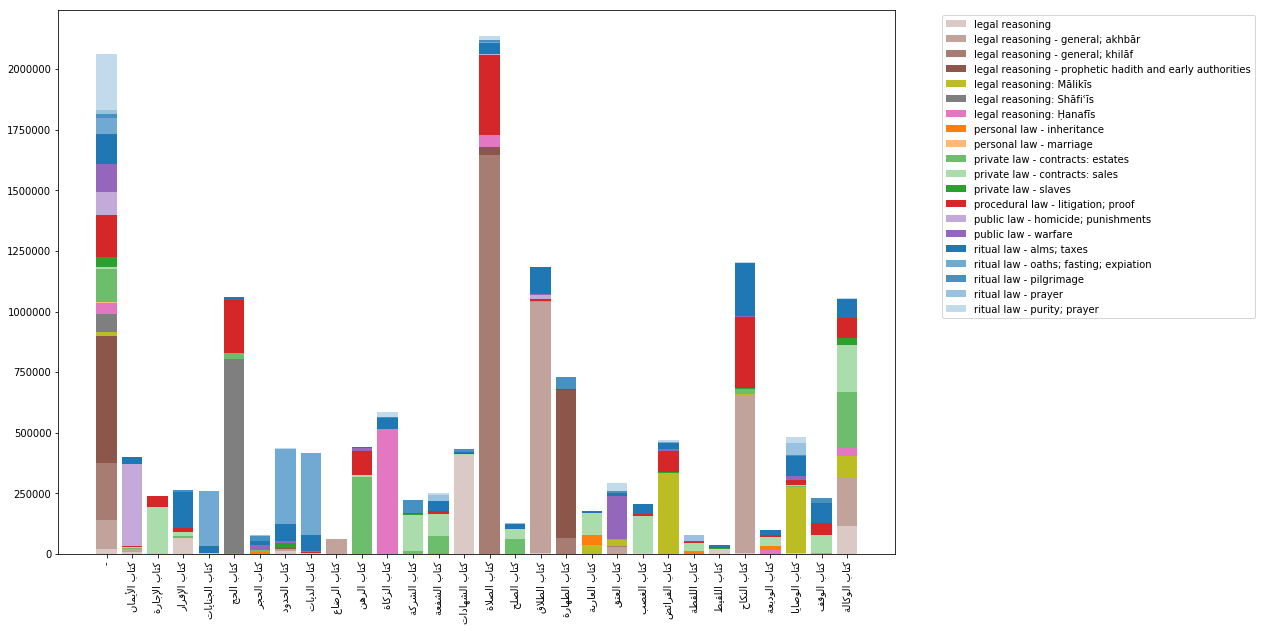

In [53]:
# The 30 most common volume names. plotted are the sizes of the chapters within those volumes
volume_counts = metadata_newind.groupby('Level1Title')['BookURI'].nunique().sort_values(ascending=False)
voltitles = volume_counts[volume_counts>1].head(30).index
meta_sub = metadata_newind[metadata_newind.Level1Title.isin(voltitles)]
plot_bars_per_topic(meta_sub, topic_names, color_dict, 'Level1Title', reshape_col1=True, aggfunc=sum)